In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load data (assuming it's in the same directory or specify the full path)
data = pd.read_excel('data lab 5.xlsx')

In [2]:
# Drop any non-decisive columns, like 'Day'
data = data.drop(columns=['Day'])


In [3]:
# Define functions to calculate entropy and Information Gain
def entropy(column):
    """Calculate the entropy of a column (target or split attribute)."""
    probabilities = column.value_counts(normalize=True)
    return -sum(probabilities * np.log2(probabilities))

def information_gain(data, split_attr, target_attr="Play?"):
    """Calculate Information Gain of a split attribute based on target attribute."""
    total_entropy = entropy(data[target_attr])
    values = data[split_attr].unique()
    # Calculate weighted entropy for each split attribute
    weighted_entropy = sum((data[data[split_attr] == v].shape[0] / data.shape[0]) * 
                           entropy(data[data[split_attr] == v][target_attr]) 
                           for v in values)
    
    return total_entropy - weighted_entropy

def best_split(data, target_attr="Play?"):
    """Determine the attribute with the highest Information Gain for splitting."""
    attributes = [col for col in data.columns if col != target_attr]
    gains = {attr: information_gain(data, attr, target_attr) for attr in attributes}
    return max(gains, key=gains.get), gains
def gini_index(column):
    probabilities = column.value_counts(normalize=True)
    return 1 - sum(probabilities**2)

def gini_gain(data, split_attr, target_attr="Play?"):
    total_gini = gini_index(data[target_attr])
    values = data[split_attr].unique()
    weighted_gini = sum((data[data[split_attr] == v].shape[0] / data.shape[0]) * 
                        gini_index(data[data[split_attr] == v][target_attr]) 
                        for v in values)
    return total_gini - weighted_gini


In [4]:
# Recursive function to build the decision tree
def id3(data, target_attr="Play?", tree=None):
    """Recursively build the ID3 decision tree."""
    
    # Get unique values of the target attribute
    target_values = data[target_attr].unique()
    
    # Stopping conditions
    if len(target_values) == 1:
        return target_values[0]  # Pure node (all values are the same)
    if data.empty or len(data.columns) == 1:
        return data[target_attr].mode()[0]  # Most common target value in case of no split attributes
    
    # Find the best attribute to split
    best_attr, gains = best_split(data, target_attr)
    
    # Initialize the tree structure
    tree = {best_attr: {}}
    
    # Recursively split the dataset for each value of the best attribute
    for value in data[best_attr].unique():
        subset = data[data[best_attr] == value].drop(columns=[best_attr])
        tree[best_attr][value] = id3(subset, target_attr)
    
    return tree

In [5]:
# Recursive function to build the decision tree using Gini Index
def gini_id3(data, target_attr="Play?", tree=None):
    """Recursively build a decision tree using Gini Index instead of entropy-based Information Gain."""
    
    # Get unique values of the target attribute
    target_values = data[target_attr].unique()
    
    # Stopping conditions
    if len(target_values) == 1:
        return target_values[0]  # Pure node (all values are the same)
    if data.empty or len(data.columns) == 1:
        return data[target_attr].mode()[0]  # Most common target value if no split attributes left
    
    # Find the best attribute to split based on Gini Gain
    best_attr, _ = max(
        {attr: gini_gain(data, attr, target_attr) for attr in data.columns if attr != target_attr}.items(),
        key=lambda x: x[1]
    )
    
    # Initialize the tree structure
    tree = {best_attr: {}}
    
    # Recursively split the dataset for each value of the best attribute
    for value in data[best_attr].unique():
        subset = data[data[best_attr] == value].drop(columns=[best_attr])
        tree[best_attr][value] = gini_id3(subset, target_attr)
    
    return tree


In [6]:
# Generate the decision tree
decision_tree = id3(data)
# Build the decision tree using Gini Index
gini_decision_tree = gini_id3(data)
gini_decision_tree

{'Outlook': {'Sunny': {'Temp': {'Hot': 'No', 'Mild': 'Yes', 'Cool': 'Yes'}},
  'Overcast': 'Yes',
  'Rain': {'Temp': {'Mild': {'Humidity': {'High': {'Wind': {'Weak': 'Yes',
        'Strong': 'No'}},
      'Normal': 'Yes'}},
    'Cool': {'Wind': {'Weak': 'No', 'Strong': 'Yes'}}}}}}

In [7]:
# Visualization function using networkx and matplotlib
def visualize_tree(tree, parent_name='', graph=None, pos=None, level=0, width=2., vert_gap=0.5):
    if pos is None:
        pos = {}
    if graph is None:
        graph = nx.Graph()
    
    for key, value in tree.items():
        if isinstance(value, dict):
            node_name = f"{key}\n"  # Internal node
            graph.add_node(node_name)
            if parent_name:
                graph.add_edge(parent_name, node_name)
            pos = visualize_tree(value, node_name, graph=graph, pos=pos, level=level+1,
                                 width=width/2., vert_gap=vert_gap)
        else:
            leaf_name = f"{key} = {value}"  # Leaf node with class label
            graph.add_node(leaf_name)
            graph.add_edge(parent_name, leaf_name)
            pos[leaf_name] = (level * width, -level * vert_gap)
    
    pos[parent_name] = (level * width, -level * vert_gap)
    return pos


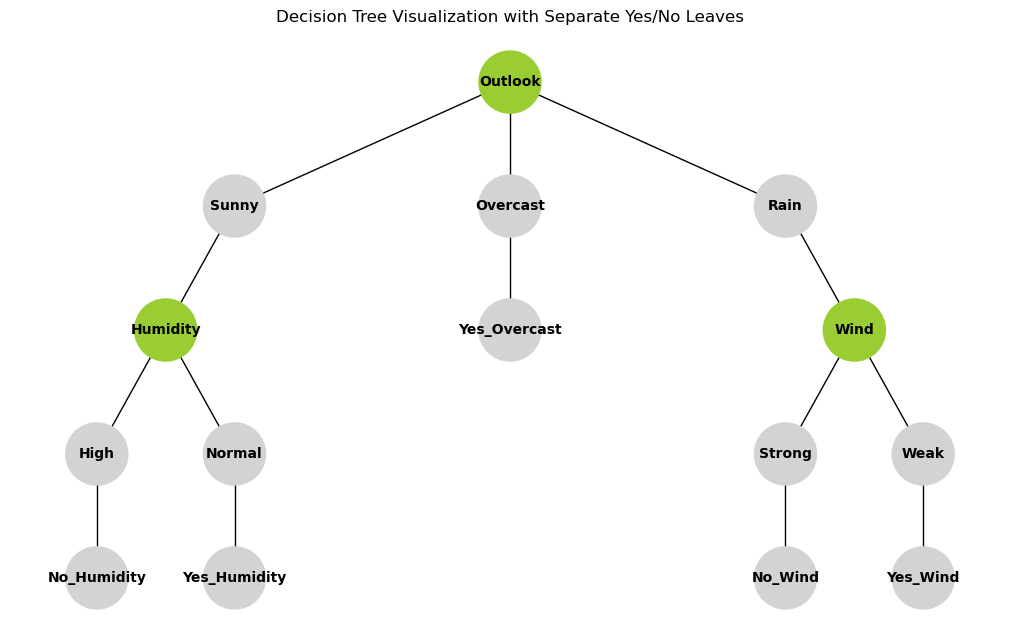

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define tree structure as per your requirements
edges = [
    ("Outlook", "Sunny"), ("Outlook", "Overcast"), ("Outlook", "Rain"),
    ("Sunny", "Humidity"), ("Rain", "Wind"),
    ("Humidity", "High"), ("Humidity", "Normal"),
    ("High", "No_Humidity"), ("Normal", "Yes_Humidity"),
    ("Wind", "Strong"), ("Wind", "Weak"),
    ("Strong", "No_Wind"), ("Weak", "Yes_Wind"),
    ("Overcast", "Yes_Overcast")
]

# Add edges to the graph
G.add_edges_from(edges)

# Define node positions manually for better layout control
pos = {
    "Outlook": (0, 3),
    "Sunny": (-2, 2), "Overcast": (0, 2), "Rain": (2, 2),
    "Humidity": (-2.5, 1), "Wind": (2.5, 1),
    "High": (-3, 0), "Normal": (-2, 0),
    "Strong": (2, 0), "Weak": (3, 0),
    "No_Humidity": (-3, -1), "Yes_Humidity": (-2, -1),
    "No_Wind": (2, -1), "Yes_Wind": (3, -1),
    "Yes_Overcast": (0, 1)
}

# Node colors to differentiate between decision nodes and leaf nodes
node_colors = {
    "Outlook": "#9acd32", "Humidity": "#9acd32", "Wind": "#9acd32",
    "Sunny": "#d3d3d3", "Overcast": "#d3d3d3", "Rain": "#d3d3d3",
    "High": "#d3d3d3", "Normal": "#d3d3d3", "Strong": "#d3d3d3", "Weak": "#d3d3d3",
    "No_Humidity": "#d3d3d3", "Yes_Humidity": "#d3d3d3", 
    "No_Wind": "#d3d3d3", "Yes_Wind": "#d3d3d3",
    "Yes_Overcast": "#d3d3d3"
}

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, arrows=False,
        node_size=2000, node_color=[node_colors.get(node, "#FFFFFF") for node in G.nodes()],
        font_size=10, font_weight="bold", font_color="black", edge_color="black")

# Highlight root and decision nodes in green
nx.draw_networkx_nodes(G, pos, nodelist=["Outlook", "Humidity", "Wind"], node_color="#9acd32")

# Display the plot
plt.title("Decision Tree Visualization with Separate Yes/No Leaves")
plt.show()


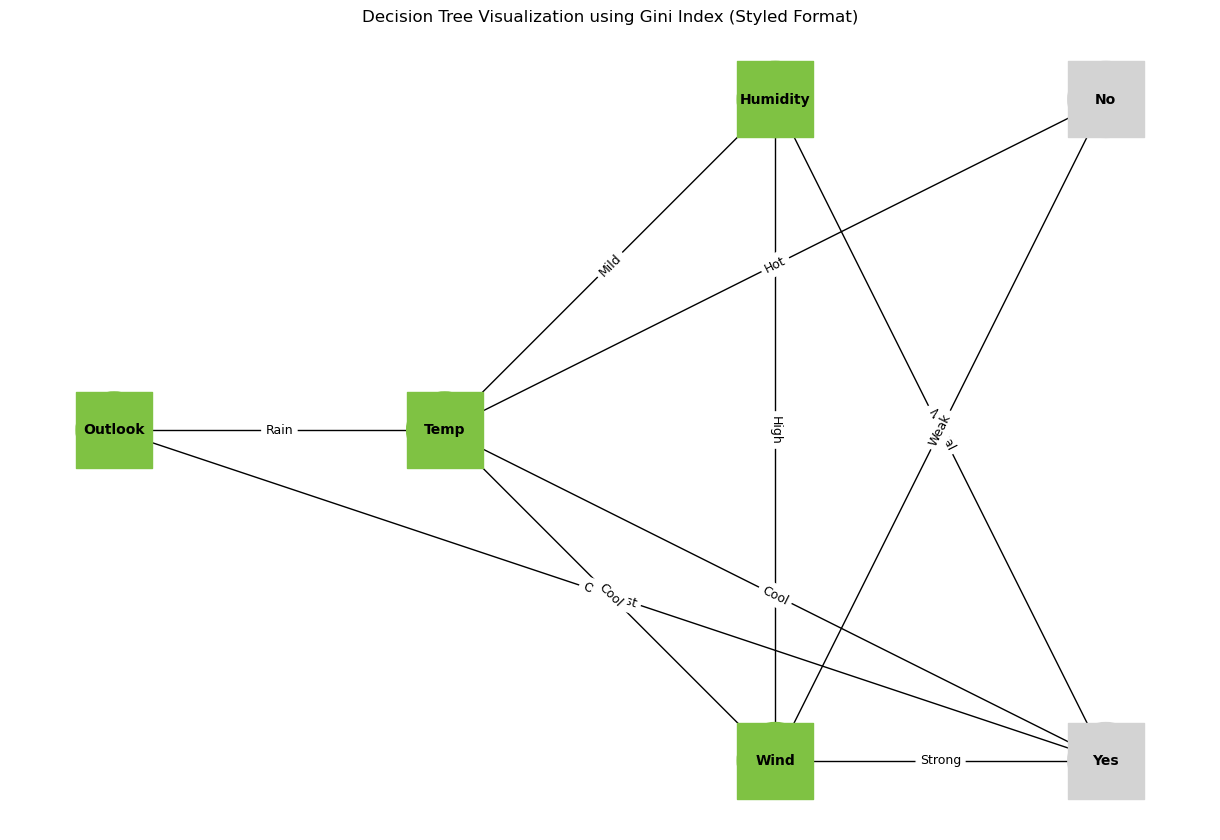

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

def add_edges(graph, tree, parent=None, depth=0):
    """Recursively add nodes and edges to the graph from the tree structure."""
    if isinstance(tree, dict):
        for attribute, branches in tree.items():
            if parent is None:
                parent = attribute  # Root node
                graph.add_node(parent, label=attribute, color="#7FC243", shape="box", subset=depth)  # Green for root
            for value, subtree in branches.items():
                child_label = f"{attribute} = {value}"
                if isinstance(subtree, dict):
                    # Internal node
                    subtree_label = list(subtree.keys())[0]
                    graph.add_node(subtree_label, label=subtree_label, color="#7FC243", shape="box", subset=depth + 1)
                    graph.add_edge(parent, subtree_label, label=value)
                    add_edges(graph, subtree, subtree_label, depth + 1)
                else:
                    # Leaf node
                    graph.add_node(subtree, label=subtree, color="#D3D3D3", shape="box", subset=depth + 1)
                    graph.add_edge(parent, subtree, label=value)
    else:
        # If the tree is a single leaf node
        graph.add_node(tree, label=tree, color="#D3D3D3", shape="box", subset=depth)
        graph.add_edge(parent, tree)

# Initialize the decision tree (replace `gini_decision_tree` with your actual tree variable)
gini_decision_tree = gini_id3(data)

# Create the directed graph
G = nx.DiGraph()

# Add nodes and edges recursively from the decision tree structure
add_edges(G, gini_decision_tree)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.multipartite_layout(G, subset_key="subset")  # Hierarchical layout based on subset

# Extract node properties
node_colors = [G.nodes[n].get('color', 'skyblue') for n in G.nodes]
node_labels = {n: G.nodes[n].get('label', n) for n in G.nodes}
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}

# Draw nodes, edges, and labels
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color=node_colors,
        font_size=10, font_weight="bold", font_color="black", edge_color="black", arrows=False)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black", font_size=9)

# Draw nodes with custom shapes (decision nodes as squares)
for node, attributes in G.nodes(data=True):
    shape = attributes.get('shape', 'o')
    if shape == "box":
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_shape='s', node_color=attributes.get('color', 'skyblue'), node_size=3000)

plt.title("Decision Tree Visualization using Gini Index (Styled Format)")
plt.show()


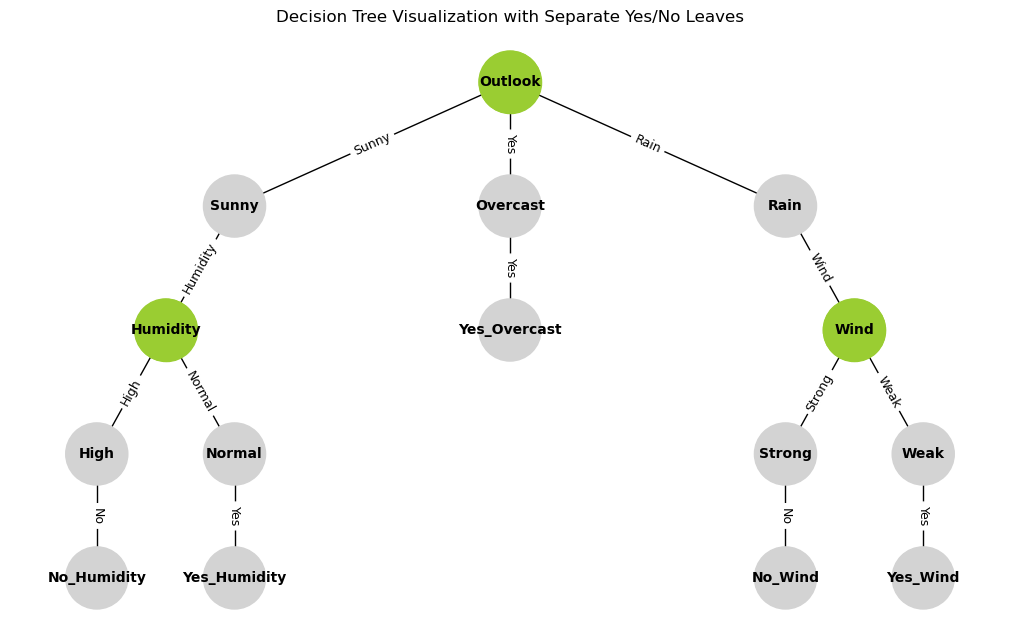

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define tree structure as per your requirements
edges = [
    ("Outlook", "Sunny"), ("Outlook", "Overcast"), ("Outlook", "Rain"),
    ("Sunny", "Humidity"), ("Rain", "Wind"),
    ("Humidity", "High"), ("Humidity", "Normal"),
    ("High", "No_Humidity"), ("Normal", "Yes_Humidity"),
    ("Wind", "Strong"), ("Wind", "Weak"),
    ("Strong", "No_Wind"), ("Weak", "Yes_Wind"),
    ("Overcast", "Yes_Overcast")
]

# Add edges to the graph
G.add_edges_from(edges)

# Define node positions manually for better layout control
pos = {
    "Outlook": (0, 3),
    "Sunny": (-2, 2), "Overcast": (0, 2), "Rain": (2, 2),
    "Humidity": (-2.5, 1), "Wind": (2.5, 1),
    "High": (-3, 0), "Normal": (-2, 0),
    "Strong": (2, 0), "Weak": (3, 0),
    "No_Humidity": (-3, -1), "Yes_Humidity": (-2, -1),
    "No_Wind": (2, -1), "Yes_Wind": (3, -1),
    "Yes_Overcast": (0, 1)
}

# Node colors to differentiate between decision nodes and leaf nodes
node_colors = {
    "Outlook": "#9acd32", "Humidity": "#9acd32", "Wind": "#9acd32",
    "Sunny": "#d3d3d3", "Overcast": "#d3d3d3", "Rain": "#d3d3d3",
    "High": "#d3d3d3", "Normal": "#d3d3d3", "Strong": "#d3d3d3", "Weak": "#d3d3d3",
    "No_Humidity": "#d3d3d3", "Yes_Humidity": "#d3d3d3", 
    "No_Wind": "#d3d3d3", "Yes_Wind": "#d3d3d3",
    "Yes_Overcast": "#d3d3d3"
}

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, arrows=False,
        node_size=2000, node_color=[node_colors.get(node, "#FFFFFF") for node in G.nodes()],
        font_size=10, font_weight="bold", font_color="black", edge_color="black")

# Highlight root and decision nodes in green
nx.draw_networkx_nodes(G, pos, nodelist=["Outlook", "Humidity", "Wind"], node_color="#9acd32", node_size=2000)

# Add edge labels
edge_labels = {
    ("Outlook", "Sunny"): "Sunny", ("Outlook", "Overcast"): "Yes", ("Outlook", "Rain"): "Rain",
    ("Sunny", "Humidity"): "Humidity", ("Rain", "Wind"): "Wind",
    ("Humidity", "High"): "High", ("Humidity", "Normal"): "Normal",
    ("High", "No_Humidity"): "No", ("Normal", "Yes_Humidity"): "Yes",
    ("Wind", "Strong"): "Strong", ("Wind", "Weak"): "Weak",
    ("Strong", "No_Wind"): "No", ("Weak", "Yes_Wind"): "Yes",
    ("Overcast", "Yes_Overcast"): "Yes"
}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black", font_size=9)

# Display the plot
plt.title("Decision Tree Visualization with Separate Yes/No Leaves")
plt.show()
